In [2]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import college_admissions_experiments as script
import ipdb
import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns


In [43]:
def run_multi_exp(seed, args):
    np.random.seed(seed)
    b, x, y, EW, theta, w, z, y_hat, adv_idx, disadv_idx, o, theta_star, pref_vect  = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

    err_list = {}
    for env_idx in range(args.num_envs):
        dictenv = run_single_env(args, x, y, theta, z, theta_star, env_idx)
        for k, v in dictenv.items():
            err_list[f'{k}_env{env_idx}'] = v
    
    return err_list

def run_single_env(args, x, y, theta, z, theta_star, env_idx):
    y_env = y[env_idx].flatten() 
    theta_env = theta[env_idx]
    z_env = z==env_idx+1
        
    upp_limits = [x for x in range(args.applicants_per_round*2, args.num_applicants+1, args.applicants_per_round)]
        
    err_list = {m: [None] * len(upp_limits) for m in args.methods}
    for i, t in tqdm.tqdm(enumerate(upp_limits)):
        x_round = x[:t]
        y_env_round = y_env[:t]
        z_env_round = z_env[:t]
        theta_env_round = theta_env[:t]

        # filtering out rejected students
        y_env_round_selected = y_env_round[z_env_round]
        x_round_selected = x_round[z_env_round]
        theta_env_round_selected = theta_env_round[z_env_round]

        for m in args.methods:
            if m == 'ours':
                est = script.our2(x_round, y_env_round_selected, theta_env_round, z_env_round)
            elif m == '2sls':
                est = script.tsls(x_round_selected, y_env_round_selected, theta_env_round_selected)
            elif m == 'ols':
                est = script.ols(x_round_selected, y_env_round_selected)
            
            assert theta_star[env_idx].shape == est.shape, f"{theta[0].shape}, {est.shape}"
            err_list[m][i] = np.linalg.norm(theta_star[env_idx] - est )
    return err_list

n_runs = 10
cmd =f'--num-applicants 10000 --applicants-per-round 100 --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --methods ours 2sls ols'
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(run_multi_exp, args_list )

[{'ours_env0': [nan,
   nan,
   0.8528181818417379,
   0.8528181818417379,
   0.13023511412687758,
   0.13023511412687758,
   0.16559337721546805,
   0.16559337721546805,
   0.13487325695362726,
   0.13487325695362726,
   0.3077959628031037,
   0.3077959628031037,
   0.3012713390884382,
   0.3012713390884382,
   0.19647179156656594,
   0.19647179156656594,
   0.16006636938688948,
   0.12165017516172506,
   0.10871661011348424,
   0.10871661011348424,
   0.05962510252465691,
   0.040889699624640084,
   0.04031707215788231,
   0.04031707215788231,
   0.04141797931641226,
   0.04141797931641226,
   0.005503445493966964,
   0.004958181722273337,
   0.02591319783004722,
   0.016291570731104345,
   0.0414102658824182,
   0.0414102658824182,
   0.00547012340020976,
   0.006902730791569615,
   0.002799771271815177,
   0.0013866468180104715,
   0.009518598461835262,
   0.009518598461835262,
   0.014357303700618999,
   0.02037527173560104,
   0.0023886565462173607,
   0.003129902490128948,
   0.

In [44]:
# convert to dataframe.
dfs = []
for r in runs:
    df = pd.DataFrame(r)
    dfs.append(df)
df = pd.concat(dfs)
df.reset_index(inplace=True); df.rename({'index': 'iterations'}, axis=1, inplace=True)
df

,iterations,ours_env0,2sls_env0,ols_env0,ours_env1,2sls_env1,ols_env1
0,0,NaN,1.045205,0.429856,NaN,0.300347,0.333856
1,1,NaN,0.086832,0.384205,NaN,0.200569,0.364605
2,2,0.852818,0.156826,0.376108,0.579990,0.338671,0.364845
3,3,0.852818,0.105946,0.390972,0.579990,0.364285,0.356387
4,4,0.130235,0.146526,0.392511,0.413059,1.646395,0.367135
...,...,...,...,...,...,...,...
985,94,0.067919,0.114675,0.194642,0.023277,0.082686,0.196626
986,95,0.067973,0.113915,0.194593,0.023277,0.081331,0.196663
987,96,0.067804,0.113537,0.194191,0.026937,0.081769,0.196693
988,97,0.068379,0.113340,0.194304,0.023791,0.081058,0.196521


In [45]:
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: x.split('_')[0])
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong

,iterations,env,error,method
0,0,env0,NaN,ours
1,1,env0,NaN,ours
2,2,env0,0.852818,ours
3,3,env0,0.852818,ours
4,4,env0,0.130235,ours
...,...,...,...,...
5935,94,env1,0.196626,ols
5936,95,env1,0.196663,ols
5937,96,env1,0.196693,ols
5938,97,env1,0.196521,ols


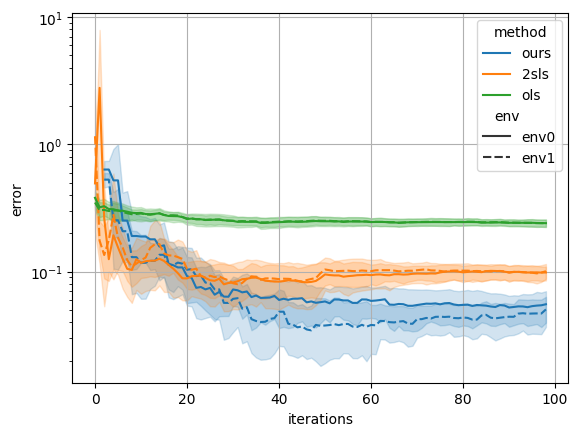

In [46]:
# dflong = pd.melt(df, id_vars='iterations', value_vars=('ours_env0', 'ours_env1'), var_name='env', value_name='error')
fig,ax=plt.subplots()
sns.lineplot(dflong, x='iterations', y='error', style='env', errorbar=('ci', 95), ax=ax, hue='method')
ax.grid()
ax.set_yscale('log')

In [2]:
# from scipy.stats import ttest_ind
# condition = 'w'
# def test(vect, args, condition, show_first_env=True, plot=False):
    # assert vect.shape == (args.num_applicants,)
    # assert z.shape == (args.num_applicants, )
    # assert condition in ('z', 'w')
    # out1, out2 = [], []
    # for env_idx in range(args.num_envs if not show_first_env else 1):
        # for i in range(0, args.num_applicants, args.applicants_per_round*2):

            # low1, up1 = i, i+args.applicants_per_round
            # low2, up2 = up1, up1+args.applicants_per_round
            # w_t1 = w[env_idx][low1:up1]
            # w_t2 = w[env_idx][low2:up2]
    
            # z_t1 = z[low1:up1]
            # z_t2 = z[low2:up2]

            # vect_t1 = vect[low1:up1]
            # vect_t2 = vect[low2:up2]
            # if condition == 'w':
                # c1 = w_t1 == 1
                # c2 = w_t2 == 1
            # elif condition == 'z':
                # c1 = z_t1 == env_idx+1
                # c2 = z_t2 == env_idx+1
            # data1 = vect_t1[c1]
            # data1mean = data1.mean()
            # data2 = vect_t2[c2]
            # data2mean = data2.mean()

            # if show_first_env and plot:
                # _,ax=plt.subplots(ncols=1 if show_first_env else 2,nrows=2, sharex=True, sharey=True)
                # ax[0].hist(data1, bins='auto')
                # ax[0].axvline(x=data1mean, color='k')
                # ax[0].set_title(f'env {env_idx}, round t')
                # ax[1].hist(data2, bins='auto' )
                # ax[1].axvline(x=data2mean, color='k')
                # ax[1].set_title(f'env {env_idx}, round t+1')
    
            # m1, m2 = data1.mean(), data2.mean()
            # _, pval = ttest_ind(data1, data2, axis=0, equal_var=False, nan_policy='raise')
            # print(f'm1 = {m1:.2f}, m2 = {m2:.2f}, pval = {pval}')
            # out1.append(m1-m2)
            # out2.append(pval)
    # return np.array(out1), np.array(out2)

# meandiffs, pvals = test(b.dot(theta_star[0]), args, condition='z', plot=False)
# fig,ax=plt.subplots(ncols=2)
# n_rounds = args.num_applicants / args.applicants_per_round
# n_rounds = int(n_rounds/2)
# ax[0].hist(meandiffs, bins=n_rounds)
# out, _, _ = ax[1].hist(pvals, bins=n_rounds)
# meandiffs,pvals=test(o[0], args, condition='z', plot=False)
# fig,ax=plt.subplots(ncols=2)

# n_rounds = args.num_applicants / args.applicants_per_round
# n_rounds = int(n_rounds/2)
# ax[0].hist(meandiffs, bins=n_rounds)
# ax[1].hist(pvals,bins=n_rounds)

In [3]:
def _run(seed, num_applicants, applicants_per_round, stream):
    row = {}
    for no_protocol in (True, False):
        cmd = f'--n-cores 1 --num-repeat 1 --num-applicants {num_applicants} --applicants-per-round {applicants_per_round} --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --test-run --generate 1'
        if no_protocol:
            cmd = f'{cmd} --no-protocol'
        if stream:
            cmd = f'{cmd} --stream'
        args = script.get_args(cmd)
        np.random.seed(seed)
        b, x, y, EW, theta, w, z, y_hat, adv_idx, disadv_idx, o, theta_star, pref_vect  = script.generate_data(
            args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
            )

        # considering only the first env.
        env_idx = 0 
        y_env = y[env_idx].flatten() 
        theta_env = theta[env_idx]
        z_env = z==env_idx+1
        
        # final data point or as a function on a range of students/ 
        if args.stream:
            upp_limits = [x for x in range(applicants_per_round*2, num_applicants+1, applicants_per_round)]
        else:
            upp_limits = [num_applicants]
        
        err_list = [None] * len(upp_limits)
        for i, t in tqdm.tqdm(enumerate(upp_limits)):
            # limiting to currently "total students"
            x_round = x[:t]
            y_env_round = y_env[:t]
            z_env_round = z_env[:t]
            theta_env_round = theta_env[:t]

            # picking out only the selected student
            y_env_round_selected = y_env_round[z_env_round]
            # print(x_round.shape, y_env_round.shape, z_env_round.shape, theta_env_round.shape, y_env_round_selected, z_env_round.sum() )

            est = script.our2(x_round, y_env_round_selected, theta_env_round, z_env_round)
            assert theta_star[0].shape == est.shape, f"{theta[0].shape}, {est.shape}"
            err_list[i] = np.linalg.norm(theta_star[0] - est )

        row['no-protocol' if no_protocol else 'protocol'] = err_list
    return row


In [4]:
apr = 1000 
n_rounds = 300
n_runs = 10
stream=True
args_list = [(s, apr*n_rounds, apr, stream) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(_run, args_list )


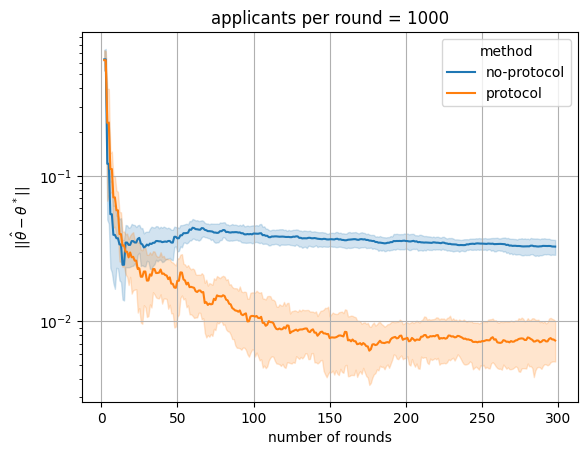

In [6]:
# adding iteration column
for run in runs:
    assert len(run['no-protocol'])==  len(run['protocol'])
    iters = np.arange(len(run['no-protocol']))
    run['iters'] = iters

# create dataframe for this n_rounds.
dfs = []
for run in runs:
    df = pd.DataFrame(run)
    dfs.append(df)
df = pd.concat(dfs)
df

dflong = pd.melt(df, id_vars=('iters',), value_vars=('no-protocol', 'protocol'), var_name='method', value_name='error')
fig,ax=plt.subplots()
sns.lineplot(
    data=dflong, x='iters', y='error', hue='method', ax=ax
)
ax.set_yscale('log')
ax.grid()

ax.set_xlabel('number of rounds')
ax.set_title('applicants per round = 1000')
ax.set_ylabel(r'$||\hat{\theta} - \theta^*||$')

plt.savefig('figures/protocol.pdf')